In [21]:
from shapely.geometry import Polygon, Point, LineString
from shapely import affinity
import matplotlib.pyplot as plt
import math
import random

In [4]:
'''
Create crosswalk, start, end, goalLine:
    crosswalk - shapely.Polygon
    start, end - shapely.Point
    goalLine - shapely.LineString

'''

# Road specification:
# width: 6m - 20m
# Crosswalk specification:
# width: 1.8m - ?m

# Create crosswalk area as Polygons
crosswalk = Polygon([(4, 0), (3, 3), (0, 6), (9, 6), (6, 3), (5, 0)])

# Create start point and end point.
start = Point((4.5, 0))
end = Point((4.5, 6))
goalLine = LineString([(0, 6), (8, 6)])

In [5]:
'''Functions that might be useful'''

# Find m and b
def fx(point1, point2):
    # m = (y1 - y2) / (x1 - x2)
    if (point1.x - point2.x) != 0:
        m = (point1.y - point2.y) / (point1.x - point2.x)
    else:
        m = None
    print("m =", m)
    
    # b = y - mx
    b = point1.y - (m * point1.x)
    print("b =", b)
    
    return m, b

# Find only m
def slope(point1, point2):
    # m = (y1 - y2) / (x1 - x2)
    if (point1.x - point2.x) != 0:
        m = (point1.y - point2.y) / (point1.x - point2.x)
    else:
        m = None
    print("m =", m)
    return m

# Find only b
def y_intercept(point, m):
    # b = y - mx
    b = point.y - (m * point.x)
    print("b =", b)
    return b

# Find distance from point to line
# Equations to find point to line:
# +=d = (mx3 - y3 + C) / ((m^2 + 1)) ^ 0.5
def distance(point, m, b):
    x = point.x
    y = point.y
    d = (m * x - y + b) / ((m ** 2 + 1)) ** 0.5
    return d

# Find a random side given a polygon
def randSide(polygon):
    x,y = polygon.exterior.xy
    n = len(x) - 1
    index = random.randint(-1, n-1)
    pointA = Point((x[index], y[index]))
    pointB = Point((x[index+1], y[index+1]))
    return LineString([pointA, pointB])

In [6]:
# Generate n intermediate points given start and end point.
def pointsOnLine(start, end, n):
    pointsOL = [start]
    line = LineString([start, end])
    gap = 1 / (n + 1)
    d = gap
    for i in range(n):
        point = line.interpolate(d, normalized=True)
        d = d + gap
        pointsOL.append(point)
    pointsOL.append(end)
    return pointsOL

In [7]:
# Rotate a single point +-90 degrees given an origin.
def pointRotate(point, origin, degree=90):
    rotated_point = affinity.rotate(point, degree, origin=origin)
    return rotated_point

In [8]:
# Find a random point on a straight line between two points.
def pointBetween(start, end, d):
    line = LineString([start, end])
    point = line.interpolate(d, normalized=True)
    return point

In [9]:
def closestEnd(point, goalLine):
    d = goalLine.project(point)
    end = goalLine.interpolate(d)
    return end

In [10]:
# Find the angle in radian between two given lines
# Formula:
# Tan(theta) = (m1 - m2) / 1 + m1 * m2
# https://www.cuemath.com/geometry/angle-between-two-lines/

def angleBetween(line1, line2):
    # Find m1 and m2
    l1_p1 = Point((line1.bounds[0], line1.bounds[1]))
    l1_p2 = Point((line1.bounds[2], line1.bounds[3]))
    m1 = slope(l1_p1, l1_p2)
    l2_p1 = Point((line2.bounds[0], line2.bounds[1]))
    l2_p2 = Point((line2.bounds[2], line2.bounds[3]))
    m2 = slope(l2_p1, l2_p2)

    # Find theta
    theta = math.atan((m1 - m2) / (1 + m1 * m2))
    
    return theta

In [32]:
# Add angle restraints:
# Absolute_max - max angle between new line and verticle line goes through start point and closest end point.
# Delta_max - max angle between new line and previous line

def shiftedPoints(start, end, crosswalk, goalLine, nInterPoints=3, maxInterPointsDistance=1.5):
    new_points = [start]
    pointsOL = pointsOnLine(start, end, nInterPoints)

    for i in range(len(pointsOL) - 2):
        start = pointsOL[1]
        end = pointsOL[2]
        done = False
        while done == False:
            chance = random.random()
            pointToRot = pointBetween(start, end, d=random.uniform(0, 1.2)) # modify d if needed
            if chance >= 0.5:
                new_point = pointRotate(pointToRot, start, degree=90)
                if crosswalk.contains(new_point):
                    segment = LineString([start, end])
                    line = LineString([new_point, new_points[-1]])
                    prev_line = None
                    if i > 0:
                        prev_line = LineString([new_points[-2], new_points[-1]])
                    if line.length <= segment.length*maxInterPointsDistance:
                        if prev_line == None:
                            done = True
                        else:
                            
                            
                            done = True
            else:
                new_point = pointRotate(pointToRot, start, degree=-90)
                if crosswalk.contains(new_point):
                    segment = LineString([start, end])
                    line = LineString([new_point, new_points[-1]])
                    if line.length <= segment.length*maxInterPointsDistance:
                        done = True
        
        new_points.append(new_point)
        new_start = new_point
        new_end = closestEnd(new_start, goalLine)
        
        pointsOL = pointsOnLine(new_start, new_end, nInterPoints-(i+1))

    # final rotate to find end point is different
    final_start = new_end
    final_end = new_start
    done = False
    while done == False:
        pointToRot = pointBetween(final_start, final_end, d=random.uniform(0, 1.2))
        chance = random.random()
        if chance >= 0.5:
            final_rot = pointRotate(pointToRot, final_start, degree=90)
            segment = LineString([final_start, final_end])
            line = LineString([new_point, new_points[-1]])
            if line.length <= segment.length*maxInterPointsDistance:
                done = True
        else:
            final_rot = pointRotate(pointToRot, final_start, degree=-90)
            segment = LineString([final_start, final_end])
            line = LineString([new_point, new_points[-1]])
            if line.length <= segment.length*maxInterPointsDistance:
                done = True
    new_points.append(final_rot)
                    
    return new_points

POINT (4.5 0)
visualization:
POINT (4.5 0)
mid reference: POINT (4.5 0)
POINT (4.640614565818304 1.5)
mid reference: POINT (4.5 1.5)
POINT (3.4067624323090637 3)
mid reference: POINT (4.5 3)
POINT (4.591162030997969 4.5)
mid reference: POINT (4.5 4.5)
POINT (5.660492381592338 6)
mid reference: POINT (4.5 6)
visualization:
POINT (4.5 0)
mid reference: POINT (4.5 0)
POINT (3.543459673118413 1.5)
mid reference: POINT (4.5 1.5)
POINT (4.317451373188801 3)
mid reference: POINT (4.5 3)
POINT (4.882168505406474 4.5)
mid reference: POINT (4.5 4.5)
POINT (5.846214762614678 6)
mid reference: POINT (4.5 6)
visualization:
POINT (4.5 0)
mid reference: POINT (4.5 0)
POINT (4.921645896041314 1.5)
mid reference: POINT (4.5 1.5)
POINT (4.070625650146006 3)
mid reference: POINT (4.5 3)
POINT (2.570625650146006 4.5)
mid reference: POINT (4.5 4.5)
POINT (3.1634398466097187 6)
mid reference: POINT (4.5 6)
visualization:
POINT (4.5 0)
mid reference: POINT (4.5 0)
POINT (4.915360657789416 1.5)
mid reference:

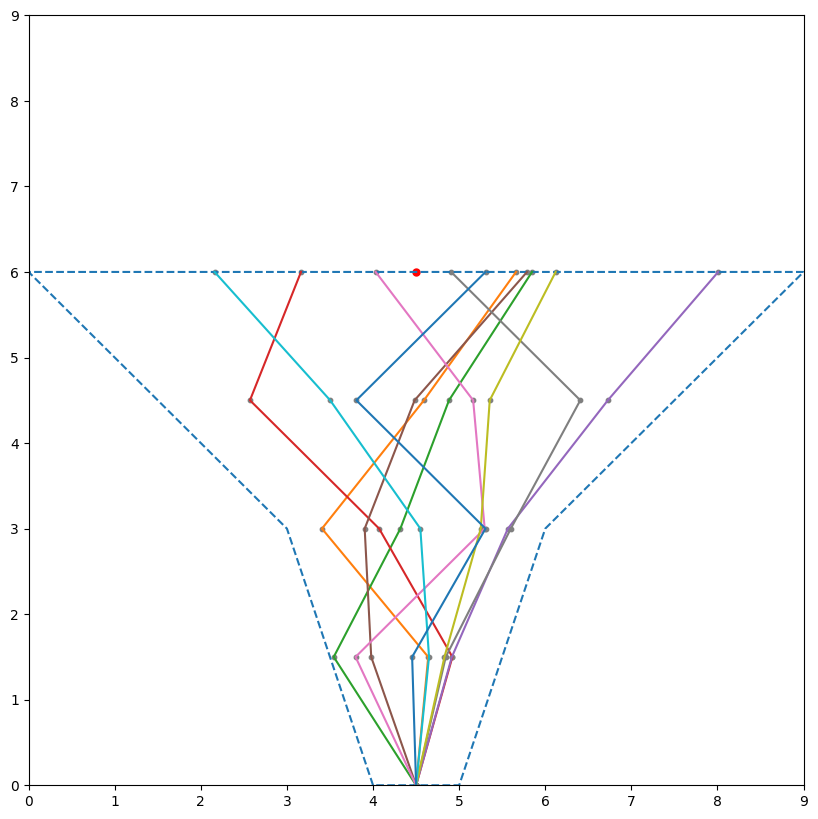

In [33]:
# Plot polygons and points

plt.rcParams["figure.figsize"] = (10,10)
x,y = crosswalk.exterior.xy
plt.plot(x,y, '--')
plt.scatter(end.x, end.y, s=25, color='red')

p = pointsOnLine(start, end, 3)
l = LineString([start, end])

coor = l.bounds
p1 = Point((coor[0], coor[1]))
print(p1)

for i in range(10):
    line_x = []
    line_y = []

    new_points = shiftedPoints(start, end, crosswalk, goalLine)
    print("visualization:")

    for i in range(len(new_points)):
        line_x.append(new_points[i].x)
        line_y.append(new_points[i].y)
        print(new_points[i])
        plt.scatter(new_points[i].x, new_points[i].y, s=10, color='grey')
        
        print("mid reference:", p[i])

    plt.plot(line_x, line_y)
plt.xlim(0, 9)
plt.ylim(0, 9)
plt.savefig('trial.png')